In [370]:
import pandas as pd
import numpy as np
from statistics import stdev, mean
from scipy import stats
import sklearn
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, roc_auc_score, auc, f1_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [371]:
heart_data = pd.read_csv('heart_input.csv')

In [372]:
labels = heart_data['heart disease']
features = heart_data.drop('heart disease',axis=1)

The dataset describes features that people have and how it might relate to that person having heart disease. There are continuous features, which have infinite values between any two variables. The continuous features are age, bp, cholestrol, max hr and oldpeak. The rest are categorial features which mean that they can only take a limited number of possible values. Here, the categorical features are sex, chest pain, fasting blood sugar > 120, resting ECG, angina, major vessels and defect. We will use heart disease as the label and the models will predict whether the given person has heart disease or not.

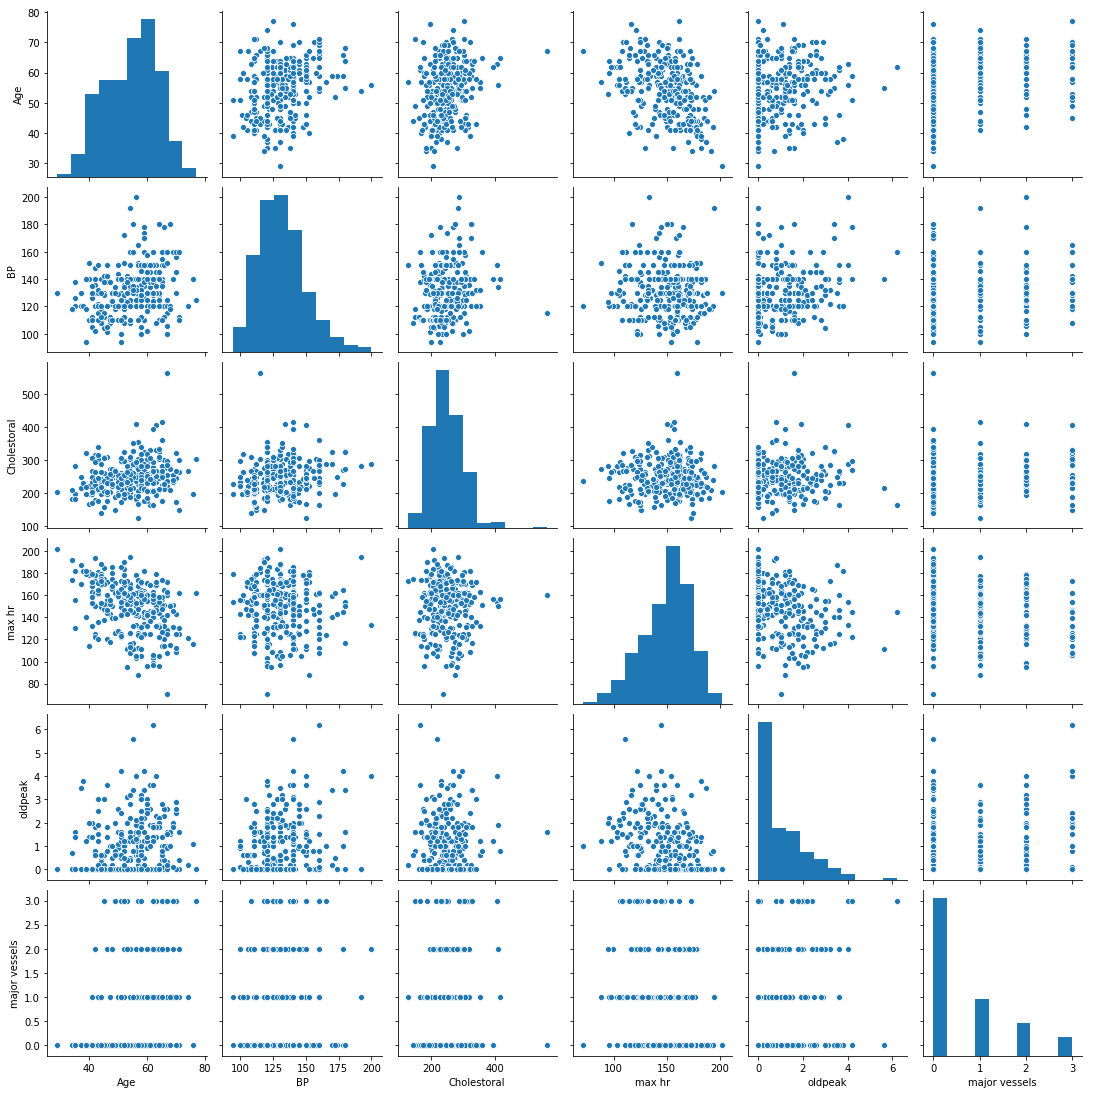

In [373]:
sns.pairplot(features)
plt.show()

In [374]:
non_numerical = features.select_dtypes(exclude=['int64', 'float64'])                                                                                                         
numerical = features.select_dtypes(include=['int64', 'float64'])                                                                                                         
                                                                                                                                                              
non_numerical = pd.get_dummies(non_numerical)                                                                                                                                 
features = pd.concat([non_numerical, numerical], axis=1)

Here we convert the categorical, non numerical data into information that can be used to train a model. We can use get_dummies to do this.

In [375]:
labels = labels.replace({'No':0,'Yes':1})

In [376]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
linear_model = LinearRegression().fit(X_train, y_train)
logistic_model = LogisticRegression().fit(X_train, y_train)

In [386]:
y_score1 = linear_model.score(X_test,y_test)
y_score2 = logistic_model.score(X_test,y_test)

In [378]:
linear_coefficient_model = LinearRegression().fit(features,labels)
logistic_coefficient_model = LogisticRegression().fit(features,labels)
print(linear_coefficient_model.coef_)
print(logistic_coefficient_model.coef_)


[ 0.08250646 -0.08250646  0.17137209 -0.0032963  -0.04459474 -0.12348105
  0.02017052 -0.02017052  0.0092985   0.05152049 -0.06081899 -0.04381997
  0.04381997 -0.02421569  0.06445641 -0.04024072 -0.03539122 -0.09611521
  0.13150644 -0.00136923  0.00212682  0.00048    -0.00227914  0.04782094
  0.12511257]
[[ 0.55905495 -0.8030618   0.99859528  0.04508522 -0.55700906 -0.73067829
   0.01008305 -0.2540899   0.14795419  0.01856164 -0.41052268 -0.40535962
   0.16135277 -0.19915901  0.34147558 -0.38632342 -0.41752967 -0.60600791
   0.77953073 -0.02529575  0.01989496  0.0057834  -0.02465582  0.39580555
   1.07279372]]


The coefficients are different for the linear and logistic models. This is because different regression models might weight features differently.

In [379]:
y_pred_lin = linear_model.predict(X_test)
y_pred_log = logistic_model.predict_proba(X_test)[:,1]


In [380]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_pred_lin)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_pred_log)
lin_auc = roc_auc_score(y_test, y_pred_lin)
log_auc = roc_auc_score(y_test, y_pred_log)
print('roc_auc_score for Linear regression: ', lin_auc)
print('roc_auc_score for Logistic Regression: ', log_auc)
lin_f1 = {}
log_f1 = {}
max_f1_lin = -9999
max_f1_log = -9999
for i in threshold1:
    y_pred_round = []
    for val in y_pred_lin:
        if val > i:
            y_pred_round.append(1)
        else:
            y_pred_round.append(0)
    lin_f1[i] = f1_score(y_test, y_pred_round)
        
for i in threshold2:
    y_pred_round = []
    for val in y_pred_log:
        if val > i:
            y_pred_round.append(1)
        else:
            y_pred_round.append(0)
    log_f1[i] = f1_score(y_test, y_pred_round)
            
lin_threshold = max(lin_f1, key=lin_f1.get)

log_threshold = max(log_f1, key=log_f1.get)
print("For the linear regression, the largest f1 score is {}, and its corresponsing optimal threshold is {}".format(
    lin_f1[lin_threshold], lin_threshold))
print("For the logistic regression, the largest f1 score is {}, and its corresponsing optimal threshold is {}".format(
    log_f1[log_threshold], log_threshold))

('roc_auc_score for Linear regression: ', 0.9422799422799423)
('roc_auc_score for Logistic Regression: ', 0.9624819624819624)
For the linear regression, the largest f1 score is 0.844444444444, and its corresponsing optimal threshold is 0.351380053249
For the logistic regression, the largest f1 score is 0.878048780488, and its corresponsing optimal threshold is 0.430400620512


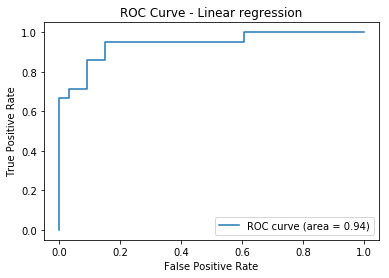

In [381]:
plt.plot(false_positive_rate1, true_positive_rate1,
         label='ROC curve (area = %0.2f)' % lin_auc)
plt.title('ROC Curve - Linear regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

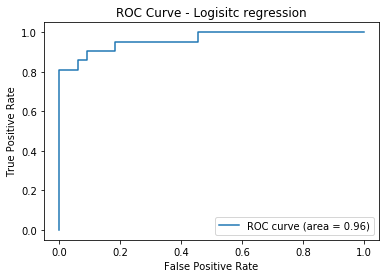

In [382]:
plt.plot(false_positive_rate2, true_positive_rate2, 
         label='ROC curve (area = %0.2f)' % log_auc)
plt.title('ROC Curve - Logisitc regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [383]:
num_of_folds = 5
max_iter = 1e8

auc_dict = {'log_reg': 0, 'lin_reg': 0}
f1_dict = {'log_reg': 0, 'lin_reg': 0}
lin_auc = []
log_auc = []
lin_f1_2 = []
log_f1_2 = []
skf=StratifiedKFold(n_splits=num_of_folds, shuffle=True)
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels.iloc[train_index].values.ravel(), labels.iloc[test_index].values.ravel()
    
    lin_regressor = LinearRegression().fit(X_train, y_train)
    
    
    log_regressor   = LogisticRegression(penalty='l2', max_iter = max_iter)
    log_regressor.fit(X_train, y_train)
    log_pred   =   log_regressor.predict(X_test) 
    lin_pred   =   lin_regressor.predict(X_test)
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, lin_pred)
#     print(len(threshold1))
#     print(len(y_test))
    lin_round = []
    for i in threshold1:
        y_pred_round = []
        for val in lin_pred:
            if val > i:
                y_pred_round.append(1)
            else:
                y_pred_round.append(0)

        lin_round.append(f1_score(y_test, y_pred_round))
    lin_f1_2.append(max(lin_round))
    log_f1_2.append(f1_score(y_test, log_pred))
    
    lin_auc.append(roc_auc_score(y_test, lin_pred))
    log_auc.append(roc_auc_score(y_test, log_pred))
    auc_dict['lin_reg']   += roc_auc_score(y_test, lin_pred)/num_of_folds
    auc_dict['log_reg']   += roc_auc_score(y_test, log_pred)/num_of_folds

# print(log_auc)
# print(lin_auc)
print(lin_f1_2)
print(log_f1_2)

[0.875, 0.875, 0.7755102040816326, 0.7826086956521738, 0.8695652173913043]
[0.9166666666666666, 0.8799999999999999, 0.6976744186046512, 0.7906976744186046, 0.888888888888889]


The features are different for each fold because every fold uses a different training and testing set for the features.

In [384]:
print ('The mean of the AUROC of the linear regression model is {}.'.format(auc_dict['lin_reg']))
print ('The 95% confidence interval of the AUROC of the linear regression model is {}'.format(
       stats.norm.interval(0.95, loc=auc_dict['lin_reg'], scale=stdev(lin_auc)/sqrt(num_of_folds))))

print ('The mean of the AUROC of the logistic regression model is {}'.format(auc_dict['log_reg']))
print ('The 95% confidence interval of the AUROC of the logistic regression model is {}'.format(
       stats.norm.interval(0.95, loc=auc_dict['log_reg'], scale=stdev(log_auc)/sqrt(num_of_folds))))

The mean of the AUROC of the linear regression model is 0.909166666667.
The 95% confidence interval of the AUROC of the linear regression model is (0.8683467891023962, 0.9499865442309372)
The mean of the AUROC of the logistic regression model is 0.856666666667
The 95% confidence interval of the AUROC of the logistic regression model is (0.7926440931845318, 0.9206892401488016)


In [385]:
print ('The mean of the f1 score of the linear regression model is {}'.format(mean(lin_f1_2)))
print ('The 95% confidence interval of the f1 of the linear regression model is {}'.format(
       stats.norm.interval(0.95, loc=mean(lin_f1_2), scale=stdev(lin_f1_2)/sqrt(num_of_folds))))

print ('The mean of the f1 score of the logistic regression model is {}'.format(mean(log_f1_2)))
print ('The 95% confidence interval of the f1 of the logistic regression model is {}'.format(
       stats.norm.interval(0.95, loc=mean(log_f1_2), scale=stdev(log_f1_2)/sqrt(num_of_folds))))

The mean of the f1 score of the linear regression model is 0.835536823425
The 95% confidence interval of the f1 of the linear regression model is (0.7902510551141637, 0.8808225917358805)
The mean of the f1 score of the logistic regression model is 0.834785529716
The 95% confidence interval of the f1 of the logistic regression model is (0.75587508414919, 0.9136959752823345)
